# 0. Install and import packages

In [7]:
%pip install torch

# 1. Soft probablistic F1 Loss

## 1.0. Utils

In [19]:
import pandas
import numpy
import torch

In [20]:
import sys

sys.path.insert(0, "..")

%load_ext autoreload
%autoreload 2

pandas.options.mode.chained_assignment = None  # default='warn'
pandas.options.display.float_format = '{:,.4f}'.format

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def compute_proba_f1(y_true: numpy.ndarray, 
                     pred_proba: numpy.ndarray, 
                     working_point: float):

    epsilon = 1e-7

    y_true_reshape = y_true.values.copy().astype(float).ravel()
    y_true_multiclass = numpy.zeros((y_true_reshape.shape[0], 2))
    y_true_multiclass[:, 1] = y_true_reshape
    y_true_multiclass[:, 0] = 1 - y_true_reshape

    working_point_p = (working_point * 2) - 1
    proportion = (1 + working_point_p) / (1 - working_point_p)

    vector_w = [1., 1.]
    vector_w[1] = vector_w[1] * (1 / (proportion + epsilon))
    
    y_proba_multiclass = numpy.ones((pred_proba.shape[0], 2))
    y_proba_multiclass[:, 1] = pred_proba
    y_proba_multiclass[:, 0] = 1 - pred_proba

    y_proba_multiclass_w = y_proba_multiclass.copy() * vector_w
    y_proba_multiclass_w = y_proba_multiclass_w / y_proba_multiclass_w.sum(axis=1).reshape(len(y_proba_multiclass_w), 1)

    p_tp = (y_true_multiclass * y_proba_multiclass_w).sum(axis=0).astype(float)
    p_tn = ((1.0 - y_true_multiclass) * (1.0 - y_proba_multiclass_w)).sum(axis=0).astype(float)
    p_fp = ((1.0 - y_true_multiclass) * y_proba_multiclass_w).sum(axis=0).astype(float)
    p_fn = (y_true_multiclass * (1.0 - y_proba_multiclass_w)).sum(axis=0).astype(float)

    p_precision = p_tp / (p_tp + p_fp + epsilon)
    p_recall = p_tp / (p_tp + p_fn + epsilon)

    p_f1 = 2.0 * (p_precision * p_recall) / (p_precision + p_recall + epsilon)
    p_f1 = p_f1.mean()
    
    return p_f1


In [5]:
def soft_p_f1_loss_wp(model_output: torch.Tensor,
                      target: torch.Tensor,
                      working_point: float) -> torch.Tensor:
    
    epsilon = 1e-7

    target_multiclass = torch.zeros((target.shape[0], 2))
    target_multiclass[:, 1] = target
    target_multiclass[:, 0] = torch.sub(1, target)

    working_point_p = torch.sub(torch.mul(working_point , 2), 1)
    proportion = torch.div(torch.add(1, working_point_p), torch.sub(1, working_point_p))

    vector_w = torch.ones(1, 2)
    vector_w[:,1] = torch.mul(vector_w[:,1], torch.div(1 , torch.add(proportion, epsilon)))

    model_output_multiclass = torch.ones((model_output.shape[0], 2))
    model_output_multiclass[:, 1] = model_output
    model_output_multiclass[:, 0] = torch.sub(1, model_output)

    model_output_multiclass_w = torch.mul(model_output_multiclass, vector_w)
    model_output_multiclass_w = torch.div(model_output_multiclass_w, model_output_multiclass_w.sum(axis=1).reshape(len(model_output_multiclass_w), 1))
    
    p_tp = (target_multiclass * model_output_multiclass_w).sum(axis=0).to(torch.float32)
    p_tn = ((1.0 - target_multiclass) * (1.0 - model_output_multiclass_w)).sum(axis=0).to(torch.float32)
    p_fp = ((1.0 - target_multiclass) * model_output_multiclass_w).sum(axis=0).to(torch.float32)
    p_fn = (target_multiclass * (1.0 - model_output_multiclass_w)).sum(axis=0).to(torch.float32)

    p_precision = p_tp / (p_tp + p_fp + epsilon)
    p_recall = p_tp / (p_tp + p_fn + epsilon)

    p_f1 = 2.0 * (p_precision * p_recall) / (p_precision + p_recall + epsilon)
    
    p_f1 = p_f1.mean()  # Mean to compute the F1 score "average='macro'"

    return 1 - p_f1


## 1.1. Hypothesis: F1 and Soft Probabilistic F1 maximize similarly

If the regular F1 maximizes approximately at the same point as the probabilistic F1, its feasible to use it as a metric. Additionally, as the probabilistic F1 is differentiable, we could build a loss function based on it so it maximizes the regular F1. 

We did some experiments and our outcomes where:

* F1 and probabilistic F1 maximized at a similar point.
* soft probabilistic F1 maximized F1 score.
* You must mantain the calibration or non-calibration of the probabilities.


<img src='../data/08_reporting/f1_prob_f1.png'>

## 1.2. Check functionality: Correct Output

In this first check, we want to see whether the probabilistic f1 score and the loss give coherent outputs.

In [6]:
def compute_p_f1(y_true, y_pred, th):

    p_f1_t = -(soft_p_f1_loss_wp(model_output=torch.from_numpy(y_pred),
                                 target=torch.from_numpy(y_true),
                                 working_point=th)-1) #undo loss calculation 1-p_f1
    p_f1 = compute_proba_f1(pd.DataFrame(y_true), y_pred, working_point=th)

    return p_f1_t, p_f1

Total IB: 9.000
Comparing torch pF1 and regular pF1 with threshold = 0.000
Comparing torch pF1 and regular pF1 with threshold = 0.100
Comparing torch pF1 and regular pF1 with threshold = 0.200
Comparing torch pF1 and regular pF1 with threshold = 0.300
Comparing torch pF1 and regular pF1 with threshold = 0.400
Comparing torch pF1 and regular pF1 with threshold = 0.500
Comparing torch pF1 and regular pF1 with threshold = 0.600
Comparing torch pF1 and regular pF1 with threshold = 0.700
Comparing torch pF1 and regular pF1 with threshold = 0.800
Comparing torch pF1 and regular pF1 with threshold = 0.900


<Axes: >

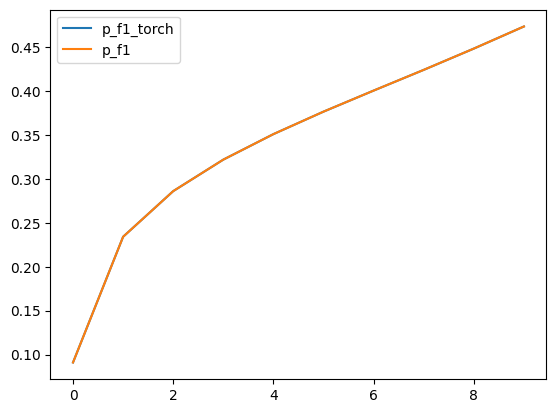

In [7]:
n = 100
ib_th = 0.9

p_f1_torch_list, p_f1_list = [], []

y_true = numpy.array(numpy.random.rand(n) >= ib_th, dtype=float)
y_pred = numpy.random.rand(n)

ib = float((y_true == 0).sum() / (y_true == 1).sum())
print(f"Total IB: {ib:.3f}")

for threshold in numpy.arange(0.0, 1.0, 0.1):
    print(f"Comparing torch pF1 and regular pF1 with threshold = {threshold:.3f}")

    p_f1_torch, p_f1 = compute_p_f1(y_true=y_true, y_pred=y_pred, th=threshold)

    p_f1_torch_list.append(p_f1_torch.item())
    p_f1_list.append(p_f1)

pf1_metrics = pd.DataFrame()
pf1_metrics["p_f1_torch"] = p_f1_torch_list
pf1_metrics["p_f1"] = p_f1_list
pf1_metrics.plot()

In [8]:
pf1_metrics

,p_f1_torch,p_f1
0,0.090910,0.090910
1,0.234224,0.234224
2,0.286232,0.286232
3,0.322148,0.322148
4,0.351217,0.351217
5,0.376845,0.376845
6,0.400842,0.400842
7,0.424456,0.424456
8,0.448717,0.448717
9,0.473923,0.473923



## 1.3. Check functionality: Correct backpropagation

Once we now our soft probabilistic f1 loss give correct outputs, we want to check if it backpropagates correctly.

In [9]:
def soft_p_f1_loss(target: torch.Tensor,
                   model_output: torch.Tensor) -> torch.Tensor:
    
    epsilon = 1e-7

    p_tp = (target * model_output).sum(axis=0).to(torch.float32)
    p_tn = ((1.0 - target) * (1.0 - model_output)).sum(axis=0).to(torch.float32)
    p_fp = ((1.0 - target) * model_output).sum(axis=0).to(torch.float32)
    p_fn = (target * (1.0 - model_output)).sum(axis=0).to(torch.float32)

    p_precision = p_tp / (p_tp + p_fp + epsilon)
    p_recall = p_tp / (p_tp + p_fn + epsilon)

    p_f1 = 2.0 * (p_precision * p_recall) / (p_precision + p_recall + epsilon)

    p_f1 = torch.mean(p_f1)  # Mean to compute the F1 score "average='macro'"

    return 1 - p_f1

In [27]:
import random

n = 15
ib_th = 0.9

w = torch.randn(1, n, requires_grad=True)
#b = torch.randn(1, n, requires_grad=True)

def model(x):
    return x * w

y_true = torch.zeros(n)
y_true[random.randint(0, n-1)] = 1 #just one class is true

x_test = torch.FloatTensor(n).uniform_(0, 1) #create torch with values from 0 to 1
x_test = x_test / x_test.sum(dim=-1).unsqueeze(-1) #make probabilities (sum to one)
x_test_hard = (x_test == x_test.max()).to(float)

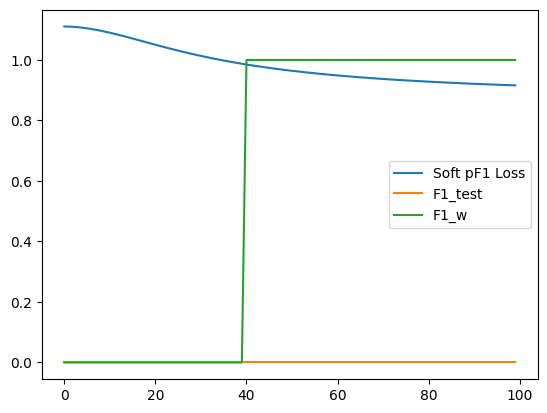

In [28]:
from sklearn.metrics import f1_score
import matplotlib

losses = []
f1_scores = []
f1_w_scores = []

for i in range(100):
    y_pred=model(x_test)
    y_pred_hard = (y_pred == y_pred.max()).to(float)[0]
    loss=soft_p_f1_loss(y_true, y_pred)

    losses.append(loss.detach().item())
    f1_scores.append(f1_score(y_true, x_test_hard))
    f1_w_scores.append(f1_score(y_true, y_pred_hard.detach()))

    loss.backward()
    with torch.no_grad():
        w -= w.grad * 1e-1
        #w.grad.zero_()

pandas.DataFrame({"Soft pF1 Loss": losses,
              "F1_test": f1_scores,
              "F1_w": f1_w_scores}).plot()
matplotlib.pyplot.show()

# 2. Binary problem

## 2.1. Load and Setup data

In [23]:
from src.example_data.load_example_data import load_multiclass_working_point_fixer_data

y_train_true, y_train_pred, y_test_true, y_test_pred = load_multiclass_working_point_fixer_data(
    data_path='C:/Users/iserrano/OneDrive - Capgemini/Documents/Repsol/Multiclass Working Point Fixer/data',
    data_mode='binary')

In [ ]:
working_point_best_f1_tr = 0.21476510067114093
ib_train = 11.9

## 2.2. Working Poing scanning vs Soft probabilistic F1 loss.

We'll perform the regular working point scanning and compare it with our proposed method.

In [24]:
from src.classification.metrics_working_point import metrics_scanning_working_points

Metrics for 'default' working point = 0.5
	 tn   8071 	//fp 90	//fn 499 	//tp 187
	 Ap0: 0.9159	 //Ap1:0.2404
	 f1:         0.3884
	 Precission: 0.6751
	 Recall:     0.2726
	 Acc:        0.9334
Metrics for max_f1 working point = 0.21476510067114093
	 tn   7788 	//fp 373	//fn 335 	//tp 351
	 Ap0: 0.9038 	 //Ap1:0.2859
	 f1:         0.4979
	 Precission: 0.4848
	 Recall:     0.5117
	 Acc:        0.92


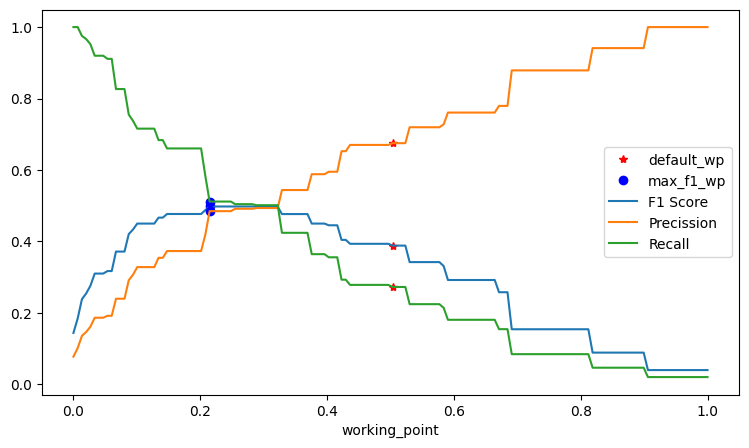

Metrics for 'default' working point = 0.5
	 tn   1999 	//fp 37	//fn 140 	//tp 35
	 Ap0: 0.9135	 //Ap1:0.1605
	 f1:         0.2834
	 Precission: 0.4861
	 Recall:     0.2
	 Acc:        0.9199
Metrics for max_f1 working point = 0.21476510067114093
	 tn   1923 	//fp 113	//fn 87 	//tp 88
	 Ap0: 0.9009 	 //Ap1:0.2595
	 f1:         0.4681
	 Precission: 0.4378
	 Recall:     0.5029
	 Acc:        0.9095


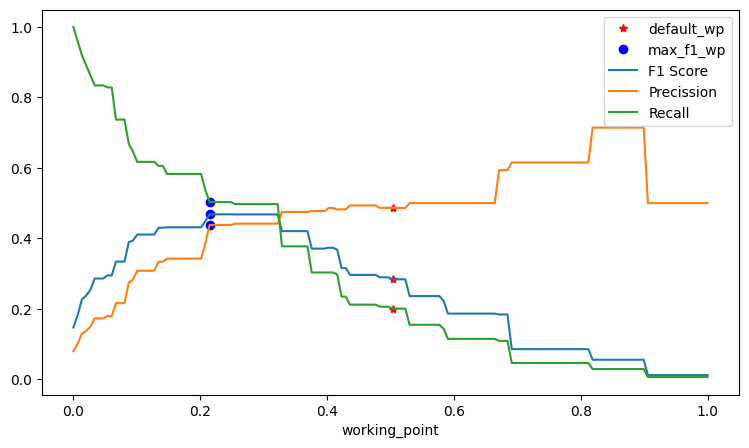

In [33]:
working_point_best_f1, axis_working_points, dict_metrics_curve = metrics_scanning_working_points(pred_proba=y_train_pred['Class 1'].to_numpy(),
                                                                                                 y_true=y_train_true['Class 1'].to_numpy(),
                                                                                                 first_working_point=0.0,
                                                                                                 last_working_point=1.0, 
                                                                                                 n_working_points=150, 
                                                                                                 plot=True, 
                                                                                                 verbose=True)


working_point_best_f1, axis_working_points, dict_metrics_curve = metrics_scanning_working_points(pred_proba=y_test_pred['Class 1'].to_numpy(),
                                                                                                 y_true=y_test_true['Class 1'].to_numpy(),
                                                                                                 first_working_point=0.0,
                                                                                                 last_working_point=1.0, 
                                                                                                 n_working_points=150, 
                                                                                                 plot=True, 
                                                                                                 verbose=True)                                                                                                 

Epoch  0/50. Train Loss: 0.10976. Val Loss: 0.11649 Train F1: 0.38837. Val F1: 0.27984. Train F1w: 0.45352. Val F1w: 0.41558
Epoch  1/50. Train Loss: 0.09195. Val Loss: 0.10972 Train F1: 0.38837. Val F1: 0.27984. Train F1w: 0.47900. Val F1w: 0.41558
Epoch  2/50. Train Loss: 0.08867. Val Loss: 0.10653 Train F1: 0.38837. Val F1: 0.27984. Train F1w: 0.49195. Val F1w: 0.46448
Epoch  3/50. Train Loss: 0.08706. Val Loss: 0.10459 Train F1: 0.38837. Val F1: 0.27984. Train F1w: 0.49747. Val F1w: 0.46448
Epoch  4/50. Train Loss: 0.08608. Val Loss: 0.10325 Train F1: 0.38837. Val F1: 0.27984. Train F1w: 0.49747. Val F1w: 0.46448
Epoch  5/50. Train Loss: 0.08543. Val Loss: 0.10227 Train F1: 0.38837. Val F1: 0.27984. Train F1w: 0.49747. Val F1w: 0.46448
Epoch  6/50. Train Loss: 0.08496. Val Loss: 0.10153 Train F1: 0.38837. Val F1: 0.27984. Train F1w: 0.49819. Val F1w: 0.46448
Epoch  7/50. Train Loss: 0.08461. Val Loss: 0.10094 Train F1: 0.38837. Val F1: 0.27984. Train F1w: 0.49819. Val F1w: 0.46448


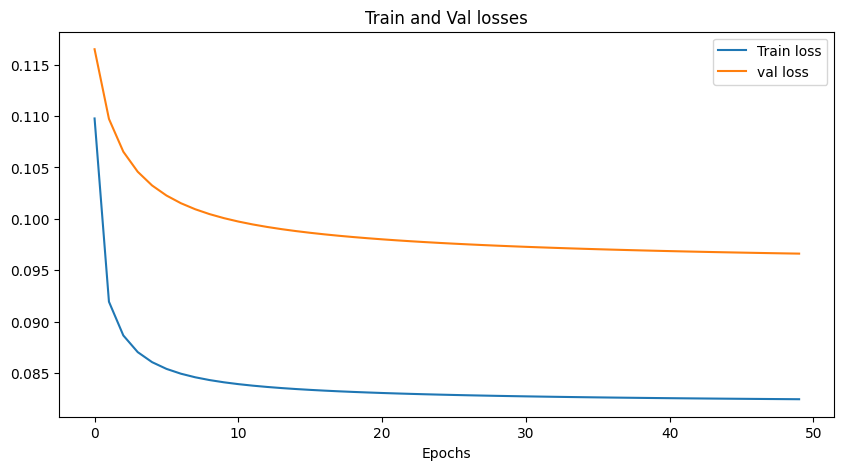

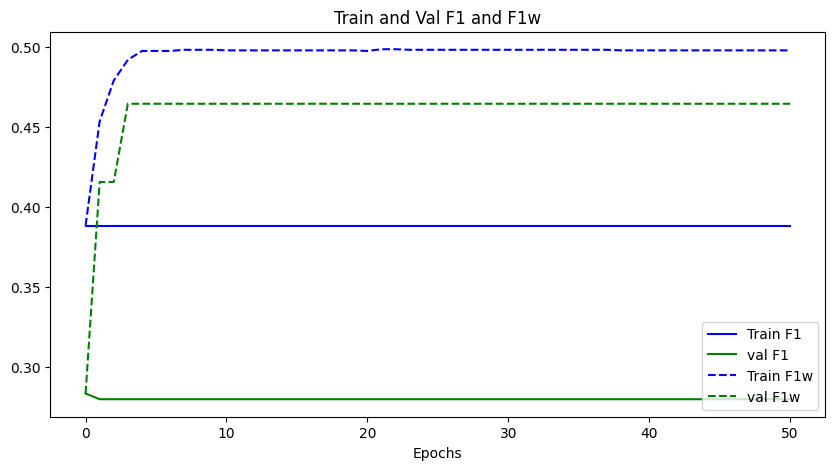

In [35]:
import warnings
warnings.filterwarnings('ignore')

from src.classification.multiclass_working_point_fixer import multiclass_Working_Point_Fixer

model_params = {"input_size": 2,
                "learning_rate": 1e-1,
                "momentum": 0.0,
                "centered": False,
                "num_epochs": 50,
                "multiclass_f1_average": 'macro',
                "train_batch_size": 128, #y_train_true.shape[0],
                "val_batch_size": 128} #y_test_true.shape[0]}

wp_fixer_glp = multiclass_Working_Point_Fixer(model_params=model_params)

wp_fixer_glp.fit(x_tr=y_train_pred.to_numpy(),
                 y_tr=y_train_true.to_numpy(),
                 x_tst=y_test_pred.to_numpy(),
                 y_tst=y_test_true.to_numpy(),
                 plot=True)

# 3. Multiclass problem: Fmodule


## 3.1. Data processing

Don't run these cells if data is already processed.

In [45]:
y_train_true, y_train_pred, y_test_true, y_test_pred = load_multiclass_working_point_fixer_data(
    data_path='C:/Users/iserrano/OneDrive - Capgemini/Documents/Repsol/Multiclass Working Point Fixer/data',
    data_mode='multiclass')

## 3.3. WP Fixer

In [38]:
from sklearn.metrics import f1_score

Original macro F1 scores:
Train F1 = 0.59984. Test F1 = 0.44018

Epoch  0/500. Train Loss: 0.47612. Val Loss: 0.48431 Train F1: 0.59940. Val F1: 0.44012. Train F1w: 0.56684. Val F1w: 0.43915
Epoch  1/500. Train Loss: 0.26353. Val Loss: 0.44227 Train F1: 0.59940. Val F1: 0.44012. Train F1w: 0.58246. Val F1w: 0.43879
Epoch  2/500. Train Loss: 0.23255. Val Loss: 0.42658 Train F1: 0.59940. Val F1: 0.44012. Train F1w: 0.59937. Val F1w: 0.43879
Epoch  3/500. Train Loss: 0.21751. Val Loss: 0.41782 Train F1: 0.59940. Val F1: 0.44012. Train F1w: 0.61439. Val F1w: 0.43879
Epoch  4/500. Train Loss: 0.20746. Val Loss: 0.41202 Train F1: 0.59940. Val F1: 0.44012. Train F1w: 0.62022. Val F1w: 0.43771
Epoch  5/500. Train Loss: 0.19985. Val Loss: 0.40780 Train F1: 0.59940. Val F1: 0.44012. Train F1w: 0.62528. Val F1w: 0.43834
Epoch  6/500. Train Loss: 0.19377. Val Loss: 0.40453 Train F1: 0.59940. Val F1: 0.44012. Train F1w: 0.62829. Val F1w: 0.43834
Epoch  7/500. Train Loss: 0.18874. Val Loss: 0.40188 

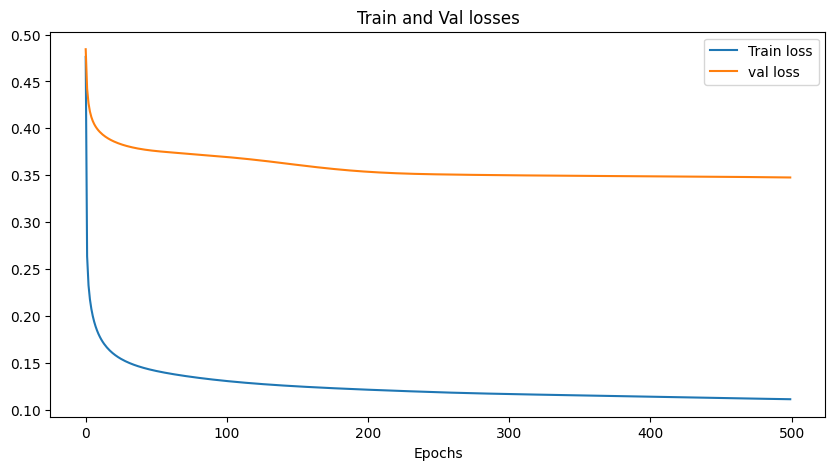

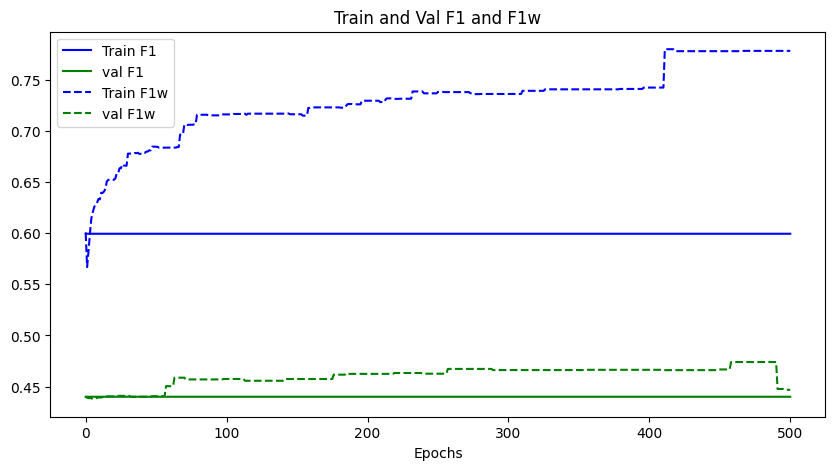

In [47]:
import warnings
warnings.filterwarnings('ignore')

model_params = {"input_size": len(y_train_pred.columns),
                "learning_rate": 1e-1,
                "momentum": 0.0,
                "centered": False,
                "num_epochs": 500,
                "multiclass_f1_average": 'macro',
                "train_batch_size": 128,
                "val_batch_size": 128}

train_f1 = f1_score(y_true=y_train_true.to_numpy().argmax(axis=1),
                    y_pred=y_train_pred.to_numpy().argmax(axis=1), average=model_params["multiclass_f1_average"])

test_f1 = f1_score(y_true=y_test_true.to_numpy().argmax(axis=1),
                   y_pred=y_test_pred.to_numpy().argmax(axis=1), average=model_params["multiclass_f1_average"])

print(f"Original {model_params['multiclass_f1_average']} F1 scores:")
print(f"Train F1 = {train_f1:.5f}. Test F1 = {test_f1:.5f}\n")

wp_fixer_fmodule = multiclass_Working_Point_Fixer(model_params=model_params)

wp_fixer_fmodule.fit(x_tr=y_train_pred.to_numpy(),
                     y_tr=y_train_true.to_numpy(),
                     x_tst=y_test_pred.to_numpy(),
                     y_tst=y_test_true.to_numpy(),
                     plot=True)

In [48]:
wp_fixer_fmodule.compute_imbalance(train_partition=y_train_true,
                                   test_partition=y_test_true)


train partition imbalance:

APOYO_TECNICO = 846.500
BOD = 25.484
BUNKER = 38.419
CHARTERING = 12.038
CLAIMS = 23.926
COMPLIANCE = 241.143
CONTRACTS = 88.211
CREDIT = 48.853
DERIVATIVES TRADING = 50.364
FINANCIALS = 4.105
MARKET RISK = 79.714
MIDDLE OFFICE = 846.500
OPERATIONS = 4.845
PHYSICAL TRADING = 4.468
PRICING = 11.021
SAP = 31.596
SMA = 42.462
SOPORTE = 16.121
VETTING = 187.333

test partition imbalance:

APOYO_TECNICO = inf
BOD = 19.190
BUNKER = 59.571
CHARTERING = 11.114
CLAIMS = 29.286
COMPLIANCE = 211.000
CONTRACTS = 211.000
CREDIT = 140.333
DERIVATIVES TRADING = 46.111
FINANCIALS = 3.930
MARKET RISK = 46.111
MIDDLE OFFICE = inf
OPERATIONS = 4.808
PHYSICAL TRADING = 3.711
PRICING = 13.621
SAP = 22.556
SMA = 59.571
SOPORTE = 22.556
VETTING = 423.000


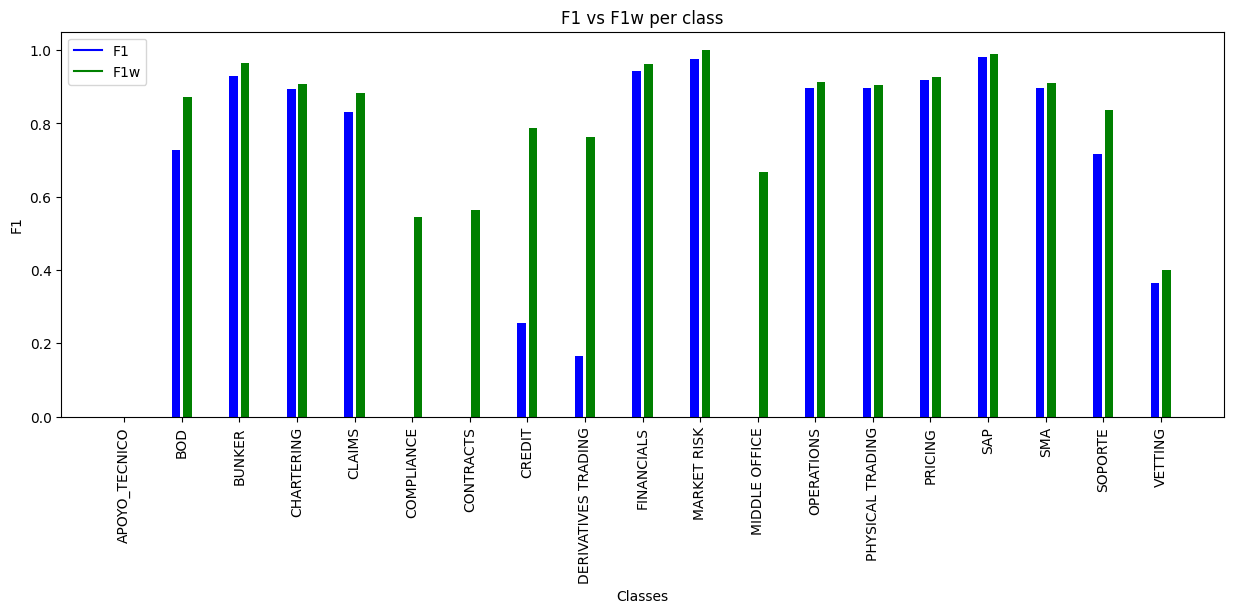

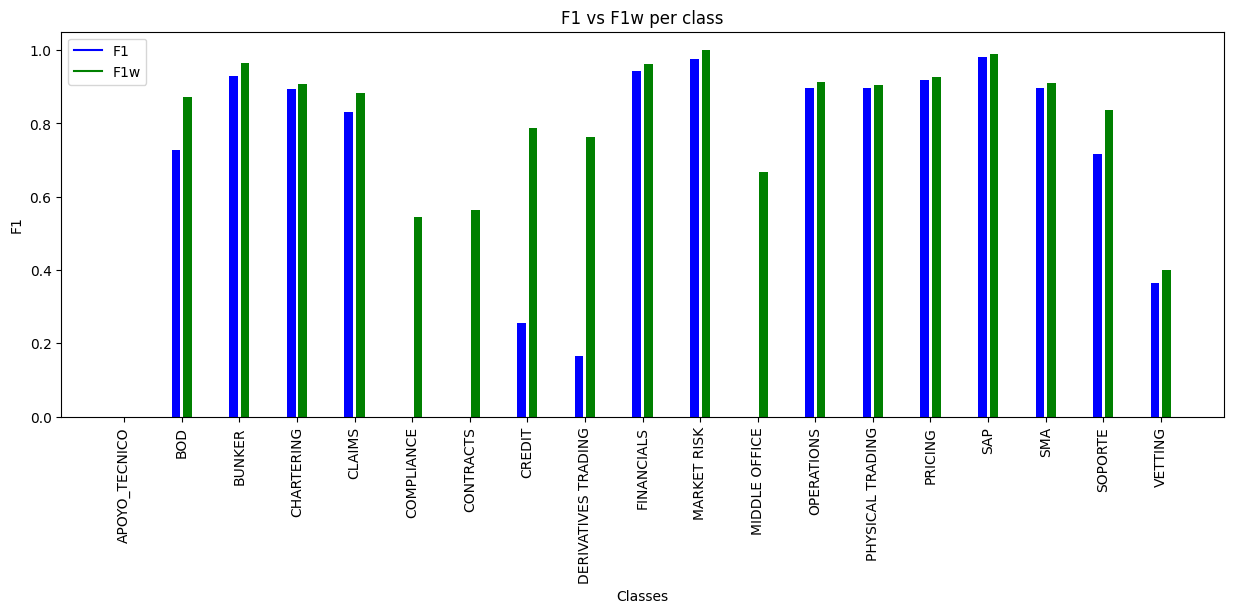

In [49]:
#train
wp_fixer_fmodule.plot_class_f1_scores(x=y_train_pred.to_numpy(),
                                      y=y_train_true.to_numpy(),
                                      c_names=list(y_test_true))
#test
wp_fixer_fmodule.plot_class_f1_scores(x=y_test_pred.to_numpy(),
                                      y=y_test_true.to_numpy(),
                                      c_names=list(y_test_true))

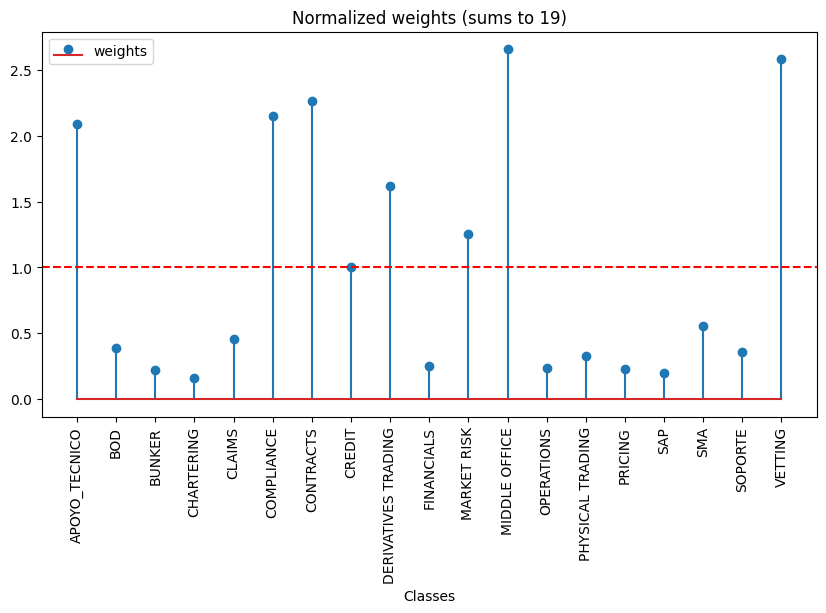

In [50]:
wp_fixer_fmodule.plot_weights(c_names=list(y_test_true), normalized=True)

In [51]:
train_f1 =f1_score(y_true=y_train_true.to_numpy().argmax(axis=1),
                   y_pred=y_train_pred.to_numpy().argmax(axis=1), average='micro') #comprobar macro

test_f1 =f1_score(y_true=y_test_true.to_numpy().argmax(axis=1),
                  y_pred=y_test_pred.to_numpy().argmax(axis=1), average='micro')

print("Original F1 scores:")
print(f"Train F1 = {train_f1:.5f}. Test F1 = {test_f1:.5f}")

Original F1 scores:
Train F1 = 0.86608. Test F1 = 0.61321
